### Building a Recommender system with Surprise

This try-it focuses on exploring additional algorithms with the `Suprise` library to generate recommendations.  Your goal is to identify the optimal algorithm by minimizing the mean squared error using cross validation. You are also going to select a dataset to use from [grouplens](https://grouplens.org/datasets/movielens/) example datasets.  

To begin, head over to grouplens and examine the different datasets available.  Choose one so that it is easy to create the data as expected in `Surprise` with user, item, and rating information.  Then, compare the performance of at least the `KNNBasic`, `SVD`, `NMF`, `SlopeOne`, and `CoClustering` algorithms to build your recommendations.  For more information on the algorithms see the documentation for the algorithm package [here](https://surprise.readthedocs.io/en/stable/prediction_algorithms_package.html).

Share the results of your investigation and include the results of your cross validation and a basic description of your dataset with your peers.



In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import researchpy as rp 
from scipy import stats
import re

from surprise import Dataset, Reader, SVD, NMF, KNNBasic, SlopeOne, CoClustering
from surprise.model_selection import cross_validate


In [25]:
movie_ratings = pd.read_csv("C:/Users/Luswata/Dropbox/ML_AI_UCBerkeley/MODULE_19_Recommendation_Systems/movies/ratings.csv")
movie_title = pd.read_csv("C:/Users/Luswata/Dropbox/ML_AI_UCBerkeley/MODULE_19_Recommendation_Systems/movies/movies.csv")
movie_tags = pd.read_csv("C:/Users/Luswata/Dropbox/ML_AI_UCBerkeley/MODULE_19_Recommendation_Systems/movies/tags.csv")

In [26]:
print(movie_ratings.head(5))
movie_ratings.shape

   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


(100836, 4)

In [27]:
print(movie_title.head(5))
movie_title.shape

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


(9742, 3)

In [28]:
print(movie_tags.head(5))
movie_tags.shape

   userId  movieId              tag   timestamp
0       2    60756            funny  1445714994
1       2    60756  Highly quotable  1445714996
2       2    60756     will ferrell  1445714992
3       2    89774     Boxing story  1445715207
4       2    89774              MMA  1445715200


(3683, 4)

In [29]:
# Merge movie_ratings with movie_tags on userId and movieId
merged_ratings_tags = pd.merge(movie_ratings, movie_tags, on=['userId', 'movieId'], how='left')
print(merged_ratings_tags.shape)

# Merge the result with movie_title on movieId
final_merged = pd.merge(merged_ratings_tags, movie_title, on='movieId', how='inner')

# Function to extract year from title
def extract_year(title):
    match = re.search(r'\((\d{4})\)', title)
    return int(match.group(1)) if match else None

# Apply the function to create a new column 'year'
final_merged['year'] = final_merged['title'].apply(extract_year)

print(final_merged.shape)

# Display the final merged DataFrame
print(final_merged.sample(n=10, random_state=1))

(102677, 6)
(102677, 9)
        userId  movieId  rating  timestamp_x              tag   timestamp_y  \
59785       28     1047     3.5   1234334914              NaN           NaN   
101142     594     7883     0.5   1108950737              NaN           NaN   
67430      474     5630     3.5   1053021641  Hannibal Lecter  1.139060e+09   
46165      314      172     1.0    834398472              NaN           NaN   
98055      298   116138     2.0   1474818441              NaN           NaN   
64004      224     2915     5.0    971812118              NaN           NaN   
69181      318    81834     4.0   1292075170              NaN           NaN   
23414      579     2599     5.0    958879901              NaN           NaN   
70440      567     5673     3.5   1525282187      bittersweet  1.525283e+09   
74470      288    39444     4.0   1157408700              NaN           NaN   

                                                    title  \
59785                     Long Kiss Goodnight

In [30]:
rp.summary_cat(final_merged['year'])

,Variable,Outcome,Count,Percent
0,year,1995.0,6193,6.03
1,,1994.0,5531,5.39
2,,1999.0,4632,4.51
3,,1996.0,4530,4.41
4,,2000.0,4335,4.22
...,...,...,...,...
101,,1903.0,2,0.00
102,,1908.0,1,0.00
103,,1917.0,1,0.00
104,,1915.0,1,0.00


In [31]:
# Filter rows where the title contains "Lord of the Rings"
lotr_movies = final_merged[final_merged['title'].str.contains("Lord of the Rings", case=False, na=False)]

# Display the filtered DataFrame
print(lotr_movies.sample(n=10, random_state=1))

       userId  movieId  rating  timestamp_x  tag  timestamp_y  \
38849     490     7153     3.5   1328145285  NaN          NaN   
37897     438     5952     4.0   1105650247  NaN          NaN   
37946     601     5952     5.0   1441639519  NaN          NaN   
38789     328     7153     4.0   1494210936  NaN          NaN   
38810     380     7153     5.0   1493419769  NaN          NaN   
38858     520     7153     4.0   1326609245  NaN          NaN   
37795     106     5952     5.0   1467360288  NaN          NaN   
37891     425     5952     4.5   1085490982  NaN          NaN   
38733     129     7153     4.5   1167376071  NaN          NaN   
11707       1     2116     5.0    964982876  NaN          NaN   

                                                   title  \
38849  Lord of the Rings: The Return of the King, The...   
37897      Lord of the Rings: The Two Towers, The (2002)   
37946      Lord of the Rings: The Two Towers, The (2002)   
38789  Lord of the Rings: The Return of the 

In [32]:
# Filter rows where the title contains "Wolf of Wall Street"
wwst_movies = final_merged[final_merged['title'].str.contains("Wolf of Wall Street", case=False, na=False)]

# Display the filtered DataFrame
print(wwst_movies.sample(n=20, random_state=321))

       userId  movieId  rating  timestamp_x              tag   timestamp_y  \
18339      47   106782     3.5   1496209142              NaN           NaN   
18366     352   106782     5.0   1493674204              NaN           NaN   
18381     537   106782     5.0   1424142673     Stock Market  1.424143e+09   
18386     564   106782     3.0   1478453646              NaN           NaN   
18379     526   106782     4.0   1502132937              NaN           NaN   
18342      68   106782     3.0   1526947699              NaN           NaN   
18335       2   106782     5.0   1445714966  Martin Scorsese  1.445715e+09   
18355     227   106782     5.0   1447210781              NaN           NaN   
18356     233   106782     2.5   1529333499              NaN           NaN   
18383     550   106782     4.0   1488629931              NaN           NaN   
18338      21   106782     3.0   1403459964              NaN           NaN   
18377     514   106782     4.0   1534052685              NaN    

In [33]:
# Get counts of each rating
rating_counts = movie_ratings['rating'].value_counts().sort_index()

# Convert to DataFrame
rating_summary = rating_counts.reset_index()
rating_summary.columns = ['rating', 'count']

# Calculate total number of ratings
total_ratings = rating_summary['count'].sum()

# Add percentage column
rating_summary['percentage'] = (rating_summary['count'] / total_ratings) * 100
rating_summary['percentage'] = rating_summary['percentage'].round(2)

# Sort by outcome (rating)
rating_summary_sorted = rating_summary.sort_values(by='rating')

# Display the sorted summary
print(rating_summary_sorted)

   rating  count  percentage
0     0.5   1370        1.36
1     1.0   2811        2.79
2     1.5   1791        1.78
3     2.0   7551        7.49
4     2.5   5550        5.50
5     3.0  20047       19.88
6     3.5  13136       13.03
7     4.0  26818       26.60
8     4.5   8551        8.48
9     5.0  13211       13.10


In [34]:
# Get counts of each rating
rating_counts = final_merged['rating'].value_counts().sort_index()

# Convert to DataFrame
rating_summary = rating_counts.reset_index()
rating_summary.columns = ['rating', 'count']

# Calculate total number of ratings
total_ratings = rating_summary['count'].sum()

# Add percentage column
rating_summary['percentage'] = (rating_summary['count'] / total_ratings) * 100
rating_summary['percentage'] = rating_summary['percentage'].round(2)

# Sort by outcome (rating)
rating_summary_sorted = rating_summary.sort_values(by='rating')

# Display the sorted summary
print(rating_summary_sorted)

   rating  count  percentage
0     0.5   1373        1.34
1     1.0   2819        2.75
2     1.5   1801        1.75
3     2.0   7563        7.37
4     2.5   5568        5.42
5     3.0  20189       19.66
6     3.5  13424       13.07
7     4.0  27208       26.50
8     4.5   8811        8.58
9     5.0  13921       13.56


In [35]:
# Drop duplicates, keeping only the last occurrence
print(final_merged.shape)
df_clean = final_merged.drop_duplicates(subset=['userId', 'movieId', 'rating'], keep='last')

#Drop timestamp features
timestamp_columns = [col for col in df_clean.columns if 'timestamp' in col]
df_clean = df_clean.drop(columns=timestamp_columns)

print(df_clean.head(5))
df_clean.shape

(102677, 9)
   userId  movieId  rating  tag             title  \
0       1        1     4.0  NaN  Toy Story (1995)   
1       5        1     4.0  NaN  Toy Story (1995)   
2       7        1     4.5  NaN  Toy Story (1995)   
3      15        1     2.5  NaN  Toy Story (1995)   
4      17        1     4.5  NaN  Toy Story (1995)   

                                        genres    year  
0  Adventure|Animation|Children|Comedy|Fantasy  1995.0  
1  Adventure|Animation|Children|Comedy|Fantasy  1995.0  
2  Adventure|Animation|Children|Comedy|Fantasy  1995.0  
3  Adventure|Animation|Children|Comedy|Fantasy  1995.0  
4  Adventure|Animation|Children|Comedy|Fantasy  1995.0  


(100836, 7)

### APPLY FILTERS

In [36]:
### Drop rows where any of the columns 'userId', 'title', or 'rating' are NaN
df = df_clean.dropna(subset=['userId', 'title', 'rating'])

# Filter the DataFrame to keep only rows where 'rating' is 1, 2, 3, 4, or 5
df = df[df['rating'].isin([1, 2, 3, 4, 5])]

# Filter to include only rows where year >= 1990
df = df[df['year'] >= 1990]

df.shape

(52054, 7)

In [37]:
# Count and list unique ratings
unique_ratings = df['rating'].unique()
unique_ratings_count = len(unique_ratings)

# Print unique ratings
print(f"Unique Ratings: {sorted(unique_ratings)}")
print(f"Number of Unique Ratings: {unique_ratings_count}")

# Existing code for number of users, items, and ratings
num_users = df['userId'].nunique()
num_items = df['movieId'].nunique()
num_ratings = df.shape[0]

print(f"Number of Users: {num_users}")
print(f"Number of Items: {num_items}")
print(f"Number of Ratings: {num_ratings}")


Unique Ratings: [1.0, 2.0, 3.0, 4.0, 5.0]
Number of Unique Ratings: 5
Number of Users: 609
Number of Items: 5770
Number of Ratings: 52054


In [38]:
# Get counts of each rating
rating_counts = df['rating'].value_counts().sort_index()

# Convert to DataFrame
rating_summary = rating_counts.reset_index()
rating_summary.columns = ['rating', 'count']

# Calculate total number of ratings
total_ratings = rating_summary['count'].sum()

# Add percentage column
rating_summary['percentage'] = (rating_summary['count'] / total_ratings) * 100
rating_summary['percentage'] = rating_summary['percentage'].round(2)

# Sort by outcome (rating)
rating_summary_sorted = rating_summary.sort_values(by='rating')

# Display the sorted summary
print(rating_summary_sorted)

   rating  count  percentage
0     1.0   2240        4.30
1     2.0   5901       11.34
2     3.0  15425       29.63
3     4.0  19566       37.59
4     5.0   8922       17.14


In [39]:
# Define the Reader object
reader = Reader(rating_scale=(1.0, 5.0))

# Load the data into Surprise format
data = Dataset.load_from_df(df[['userId', 'title', 'rating']], reader)

# Define algorithms to evaluate
algorithms = {
    'KNNBasic': KNNBasic(),
    'SVD': SVD(),
    'NMF': NMF(),
    'SlopeOne': SlopeOne(),
    'CoClustering': CoClustering()
}

# Initialize a dictionary to store the results
results = {}

for name, algorithm in algorithms.items():
    print(f"Evaluating {name}...")
    # Perform cross-validation
    cv_results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=True)
    # Store the results
    results[name] = {
        'mean_rmse': np.mean(cv_results['test_rmse']),
        'std_rmse': np.std(cv_results['test_rmse'])
    }

# Display the results
results_df = pd.DataFrame(results).T
print(results_df)




Evaluating KNNBasic...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9494  0.9498  0.9653  0.9651  0.9563  0.9572  0.0070  
Fit time          0.02    0.04    0.03    0.03    0.03    0.03    0.00    
Test time         0.21    0.24    0.22    0.28    0.25    0.24    0.03    
Evaluating SVD...
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8693  0.8816  0.8825  0.8698  0.8684  0.8743  0.0063  
Fit time          0.24    0.27    0.23   

Evaluating SVD with n_factors=2...
Evaluating SVD with n_factors=3...
Evaluating SVD with n_factors=5...
Evaluating SVD with n_factors=10...
Evaluating SVD with n_factors=20...
Evaluating SVD with n_factors=30...
Evaluating SVD with n_factors=40...
Evaluating SVD with n_factors=50...


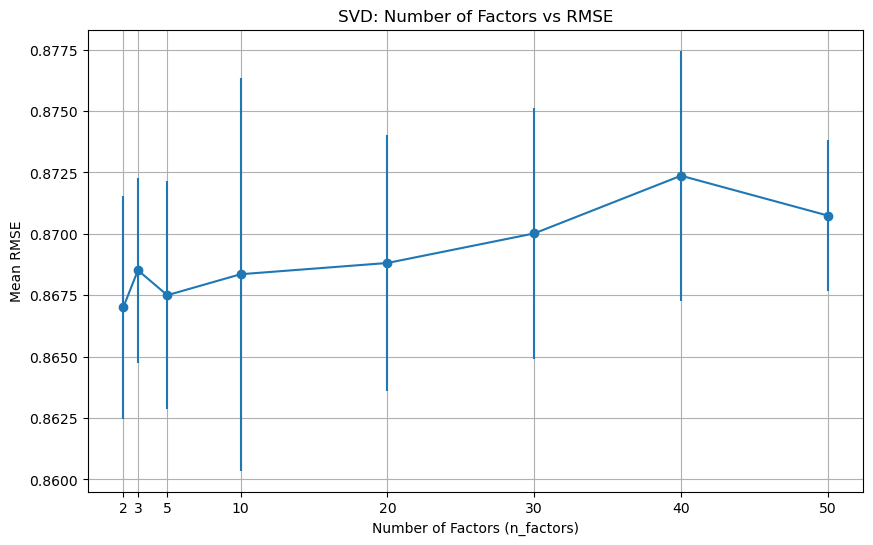

Best Parameter:
Number of Factors: 2.0
Mean RMSE: 0.8670
Standard Deviation of RMSE: 0.0045


In [40]:
# Hyperparameter tuning for different values of n_factors in the SVD algorithm

# Define the range of n_factors to test
n_factors_list = [2, 3, 5, 10, 20, 30, 40, 50]

# Define the Reader object
reader = Reader(rating_scale=(0.5, 5.0))

# Load the data into Surprise format
data = Dataset.load_from_df(df[['userId', 'title', 'rating']], reader)

# Initialize a dictionary to store the results
results = {}

# Evaluate SVD with different n_factors
for n_factors in n_factors_list:
    print(f"Evaluating SVD with n_factors={n_factors}...")
    
    # Initialize the SVD model with the current n_factors
    model = SVD(n_factors=n_factors)
    
    # Perform cross-validation
    cv_results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Store the results
    results[n_factors] = {
        'mean_rmse': np.mean(cv_results['test_rmse']),
        'std_rmse': np.std(cv_results['test_rmse'])
    }

# Convert results to DataFrame for plotting
results_df = pd.DataFrame(results).T
results_df.index.name = 'n_factors'
results_df.reset_index(inplace=True)

# Plot n_factors vs RMSE
plt.figure(figsize=(10, 6))
plt.errorbar(results_df['n_factors'], results_df['mean_rmse'], yerr=results_df['std_rmse'], fmt='-o')
plt.xlabel('Number of Factors (n_factors)')
plt.ylabel('Mean RMSE')
plt.title('SVD: Number of Factors vs RMSE')
plt.grid(True)
plt.xticks(results_df['n_factors'])
plt.show()



# Find the best parameter
best_n_factors = results_df.loc[results_df['mean_rmse'].idxmin()]

# Display the best parameter
print("Best Parameter:")
print(f"Number of Factors: {best_n_factors['n_factors']}")
print(f"Mean RMSE: {best_n_factors['mean_rmse']:.4f}")
print(f"Standard Deviation of RMSE: {best_n_factors['std_rmse']:.4f}")

In [41]:
# Example of fitting a specific algorithm (SVD in this case) on the entire dataset
print("\nFitting SVD model on the entire dataset...")
# Build the full training set
trainset = data.build_full_trainset()

# Initialize and fit the model
model = SVD(n_factors=2)
model.fit(trainset)

# Perform cross-validation again if needed
cross_val_results = cross_validate(model, data, measures=['RMSE'], cv=5, verbose=True)
print("\nSVD Cross-validation Results:")
print(cross_val_results)


Fitting SVD model on the entire dataset...
Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8771  0.8711  0.8611  0.8660  0.8624  0.8675  0.0059  
Fit time          0.07    0.07    0.07    0.07    0.07    0.07    0.00    
Test time         0.03    0.02    0.02    0.02    0.02    0.02    0.00    

SVD Cross-validation Results:
{'test_rmse': array([0.87709319, 0.87113359, 0.86105576, 0.86596794, 0.8624414 ]), 'fit_time': (0.07270669937133789, 0.06877017021179199, 0.07076334953308105, 0.07183957099914551, 0.06982278823852539), 'test_time': (0.028901338577270508, 0.024037837982177734, 0.023973941802978516, 0.022976398468017578, 0.023864269256591797)}


In [42]:
# Get predictions for the testset
testset = trainset.build_testset()
predictions_list = model.test(testset)

# Convert predictions to DataFrame
predictions_df = pd.DataFrame([{
    'userId': pred.uid,
    'movie_Title': pred.iid,
    'true_rating': pred.r_ui,
    'predicted_rating': round(pred.est, 3),
    'details': pred.details
} for pred in predictions_list])

# Display a random sample of 20 predictions
print(predictions_df.sample(n=20, random_state=1).to_string(index=False))

 userId                                  movie_Title  true_rating  predicted_rating                   details
    177                          Spider-Man 3 (2007)          1.0             2.804 {'was_impossible': False}
    394                  Addams Family Values (1993)          2.0             2.561 {'was_impossible': False}
     89                           Tuxedo, The (2002)          5.0             3.282 {'was_impossible': False}
    603                  The Devil's Advocate (1997)          3.0             3.163 {'was_impossible': False}
    105                        Ocean's Eleven (2001)          4.0             4.289 {'was_impossible': False}
    103                    Gulliver's Travels (2010)          3.0             3.501 {'was_impossible': False}
    610                              Big Fish (2003)          4.0             4.016 {'was_impossible': False}
    387                           Three Kings (1999)          3.0             3.204 {'was_impossible': False}
    380 Hi

In [43]:
# Perform paired t-test
t_stat, p_value = stats.ttest_rel(predictions_df['true_rating'], predictions_df['predicted_rating'])

# Print results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
alpha = 0.05
if p_value < alpha:
    print("There is a significant difference between true ratings and predicted ratings.")
else:
    print("There is no significant difference between true ratings and predicted ratings.")

T-statistic: -1.1464
P-value: 0.2516
There is no significant difference between true ratings and predicted ratings.


In [44]:
# Prediction for new data, and adding an average rating from the existing dataset

from surprise import Dataset, Reader, SVD
import pandas as pd

# Define the user-movie pairs for which we want predictions
prediction_data = pd.DataFrame({
    'userId': [239, 105, 279, 106, 89, 603, 317, 105],
    'title': ['Spider-Man 3 (2007)', 'Hangover, The (2009)', "The Devil's Advocate (1997)",
              'X2: X-Men United (2003)', 'Lucky Number Slevin (2006)', "Ocean's Eleven (2001)",
              "World's End, The (2013)", 'Hercules (1997)']
})

# Calculate average and median ratings for each movie title
average_ratings = df.groupby('title')['rating'].mean().reset_index()
average_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

# Prepare the testset from the prediction_data
testset = [(row['userId'], row['title'], 0) for index, row in prediction_data.iterrows()]

# Initialize and fit the model
reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(df[['userId', 'title', 'rating']], reader)
trainset = data.build_full_trainset()
model = SVD()  
model.fit(trainset)

# Get predictions
predictions = model.test(testset)

# Convert predictions to DataFrame
predictions_df = pd.DataFrame([{
    'userId': pred.uid,
    'movie_Title': pred.iid,
    'predicted_rating': round(pred.est, 3)
} for pred in predictions])

# Merge with average ratings
predictions_df = predictions_df.merge(average_ratings, left_on='movie_Title', right_on='title', how='left')
predictions_df.drop(columns=['title'], inplace=True)

# Display the predictions with average ratings
print(predictions_df)


   userId                  movie_Title  predicted_rating  average_rating
0     239          Spider-Man 3 (2007)             3.335        2.722222
1     105         Hangover, The (2009)             4.041        3.687500
2     279  The Devil's Advocate (1997)             3.129        3.378378
3     106      X2: X-Men United (2003)             4.760        3.937500
4      89   Lucky Number Slevin (2006)             4.041        3.809524
5     603        Ocean's Eleven (2001)             3.547        3.875000
6     317      World's End, The (2013)             3.216        3.363636
7     105              Hercules (1997)             4.013        3.571429


In [45]:
# Prediction for new data, and adding an average rating from the existing dataset

from surprise import Dataset, Reader, SVD
import pandas as pd

# Define the user-movie pairs for which we want predictions
prediction_data = pd.DataFrame({
    'userId': [239, 105, 279, 106, 89, 603, 317, 105],
    'title': ['Spider-Man 3 (2007)', 'Hangover, The (2009)', "The Devil's Advocate (1997)",
              'X2: X-Men United (2003)', 'Lucky Number Slevin (2006)', "Ocean's Eleven (2001)",
              "World's End, The (2013)", 'Hercules (1997)']
})

# Calculate average and median ratings for each movie title
average_ratings = df.groupby('title')['rating'].mean().reset_index()
average_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

# Prepare the testset from the prediction_data
testset = [(row['userId'], row['title'], 0) for index, row in prediction_data.iterrows()]

# Initialize and fit the model
reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(df[['userId', 'title', 'rating']], reader)
trainset = data.build_full_trainset()
model = SVD() 
model.fit(trainset)

# Get predictions
predictions = model.test(testset)

# Convert predictions to DataFrame
predictions_df = pd.DataFrame([{
    'userId': pred.uid,
    'movie_Title': pred.iid,
    'predicted_rating': round(pred.est, 3)
} for pred in predictions])

# Merge with average ratings
predictions_df = predictions_df.merge(average_ratings, left_on='movie_Title', right_on='title', how='left')
predictions_df.drop(columns=['title'], inplace=True)

# Display the predictions with average ratings
print(predictions_df)


   userId                  movie_Title  predicted_rating  average_rating
0     239          Spider-Man 3 (2007)             3.375        2.722222
1     105         Hangover, The (2009)             4.125        3.687500
2     279  The Devil's Advocate (1997)             3.158        3.378378
3     106      X2: X-Men United (2003)             4.742        3.937500
4      89   Lucky Number Slevin (2006)             4.066        3.809524
5     603        Ocean's Eleven (2001)             4.076        3.875000
6     317      World's End, The (2013)             3.317        3.363636
7     105              Hercules (1997)             4.047        3.571429


### PREDICTIONS FOR NEW DATA
userId	&nbsp;&nbsp;&nbsp;&nbsp;movie_Title  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;predicted_rating <br>
239	  &nbsp;&nbsp;&nbsp;&nbsp;  Spider-Man 3 (2007) <br>
105	  &nbsp;&nbsp;&nbsp;&nbsp;  Hangover, The (2009) <br>
279	  &nbsp;&nbsp;&nbsp;&nbsp;  The Devil's Advocate (1997) <br>
106	  &nbsp;&nbsp;&nbsp;&nbsp;  X2: X-Men United (2003) <br>
89	  &nbsp;&nbsp;&nbsp;&nbsp;   Lucky Number Slevin (2006) <br>
603   &nbsp;&nbsp;&nbsp;&nbsp;  Ocean's Eleven (2001) <br>
317	  &nbsp;&nbsp;&nbsp;&nbsp;  World's End, The (2013) <br>
105   &nbsp;&nbsp;&nbsp;&nbsp;	Hercules (1997) <br>


In [46]:

# Define the user-movie pairs for which we want predictions
prediction_data = pd.DataFrame({
    'userId': [239, 105, 279, 106, 89, 603, 317, 105],
    'title': ['Spider-Man 3 (2007)', 'Hangover, The (2009)', "The Devil's Advocate (1997)",
              'X2: X-Men United (2003)', 'Lucky Number Slevin (2006)', "Ocean's Eleven (2001)",
              "World's End, The (2013)", 'Hercules (1997)']
})

# Calculate average and median ratings for each movie title
average_ratings = df.groupby('title')['rating'].mean().reset_index()
average_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

median_ratings = df.groupby('title')['rating'].median().reset_index()
median_ratings.rename(columns={'rating': 'median_rating'}, inplace=True)

# Prepare the testset from the prediction_data
testset = [(row['userId'], row['title'], 0) for index, row in prediction_data.iterrows()]

# Initialize and fit the model
reader = Reader(rating_scale=(1.0, 5.0))
data = Dataset.load_from_df(df[['userId', 'title', 'rating']], reader)
trainset = data.build_full_trainset()
model = SVD()  
model.fit(trainset)

# Get predictions
predictions = model.test(testset)

# Convert predictions to DataFrame
predictions_df = pd.DataFrame([{
    'userId': pred.uid,
    'movie_Title': pred.iid,
    'predicted_rating': round(pred.est, 2)
} for pred in predictions])

# Merge with average and median ratings
predictions_df = predictions_df.merge(average_ratings, left_on='movie_Title', right_on='title', how='left')
predictions_df = predictions_df.merge(median_ratings, left_on='movie_Title', right_on='title', how='left')

# Drop the unnecessary columns
predictions_df.drop(columns=['title_x', 'title_y'], inplace=True)

# Round average and median ratings to 1 decimal place
predictions_df['average_rating'] = predictions_df['average_rating'].round(2)
predictions_df['median_rating'] = predictions_df['median_rating'].round(2)

# Display the predictions with average and median ratings
print(predictions_df.to_string(index=False))


 userId                 movie_Title  predicted_rating  average_rating  median_rating
    239         Spider-Man 3 (2007)              3.54            2.72            3.0
    105        Hangover, The (2009)              3.99            3.69            4.0
    279 The Devil's Advocate (1997)              3.19            3.38            3.0
    106     X2: X-Men United (2003)              4.56            3.94            4.0
     89  Lucky Number Slevin (2006)              4.17            3.81            4.0
    603       Ocean's Eleven (2001)              3.97            3.88            4.0
    317     World's End, The (2013)              3.10            3.36            4.0
    105             Hercules (1997)              4.24            3.57            4.0


In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52054 entries, 0 to 102674
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   userId   52054 non-null  int64  
 1   movieId  52054 non-null  int64  
 2   rating   52054 non-null  float64
 3   tag      638 non-null    object 
 4   title    52054 non-null  object 
 5   genres   52054 non-null  object 
 6   year     52054 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 3.2+ MB


In [48]:
df.columns

Index(['userId', 'movieId', 'rating', 'tag', 'title', 'genres', 'year'], dtype='object')